## Solution Planning

- First look at the dataset.
- Cleaning Dataset.
- EDA.
- Modeling.
- Modeling evaluation.
- Solution delivery.

## Imports

In [59]:
import html
import plotly
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pandas_profiling import ProfileReport

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

### Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['font.size'] = 50
  
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()

def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(float(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Load Dataset

In [3]:
df = pd.read_csv('../data/churn.csv')

## First Look at the Dataset.

In [4]:
# Check first rows

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Check df shape

df.shape

(10000, 14)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [7]:
# Check dtypes

df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
# Check for NAN

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Observations:**
- At the first look, the dataset seems to be already pretty cleaned.
- Gender must to be encoded.

## Data Cleaning

In [9]:
df2 = df.copy()

In [10]:
# exclude RowNumber column - this columns in just an row index and is not necessary.

df2.drop(columns = 'RowNumber', inplace=True)

In [11]:
df2.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<AxesSubplot:xlabel='CreditScore'>

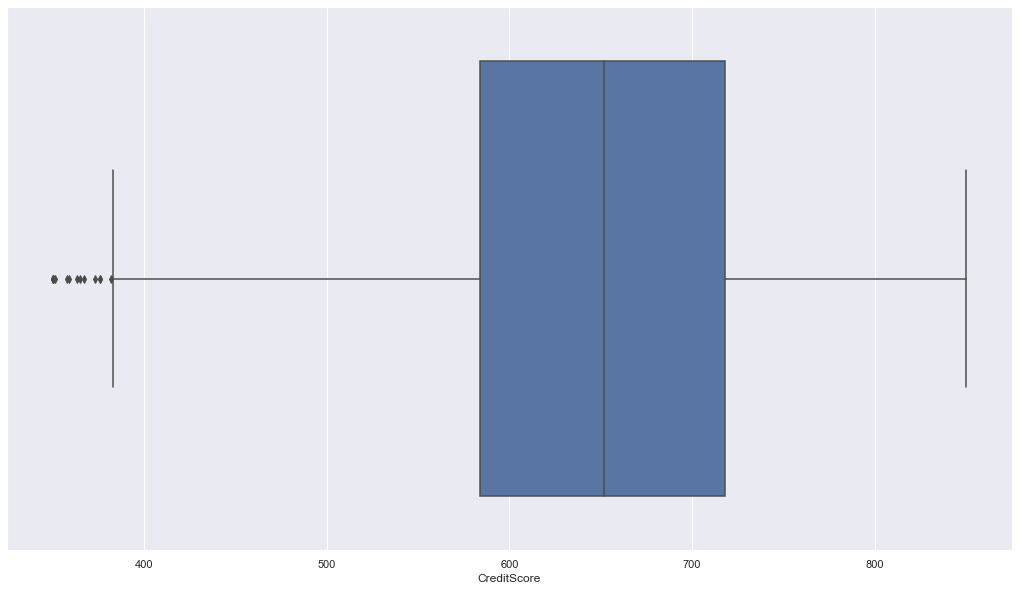

In [12]:
sns.boxplot(x = df2['CreditScore'])

<AxesSubplot:xlabel='Age'>

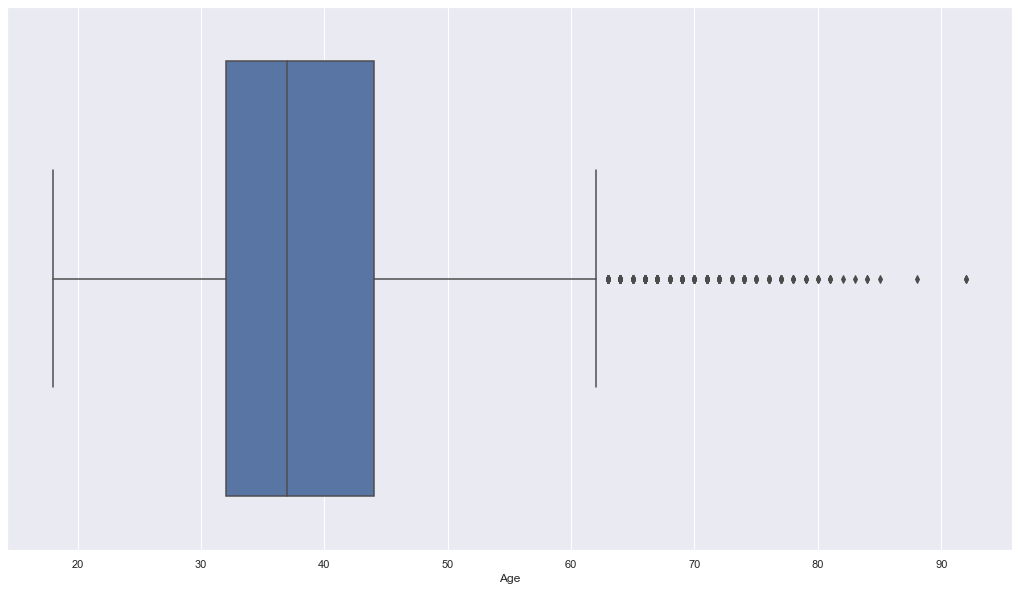

In [13]:
sns.boxplot(x = df2['Age'])

<AxesSubplot:xlabel='Balance'>

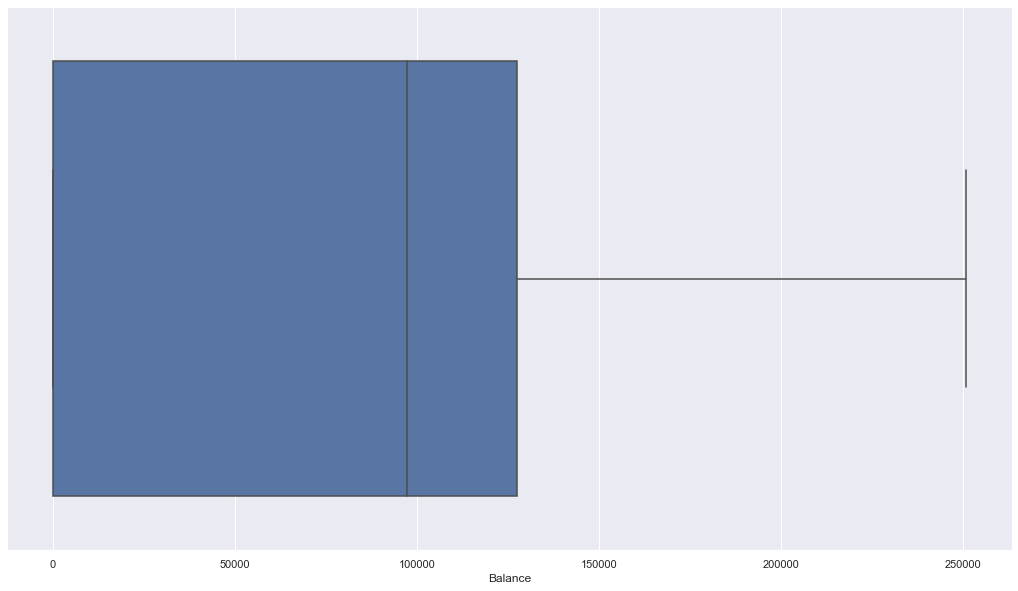

In [14]:
sns.boxplot(x = df2['Balance'])

<AxesSubplot:xlabel='EstimatedSalary'>

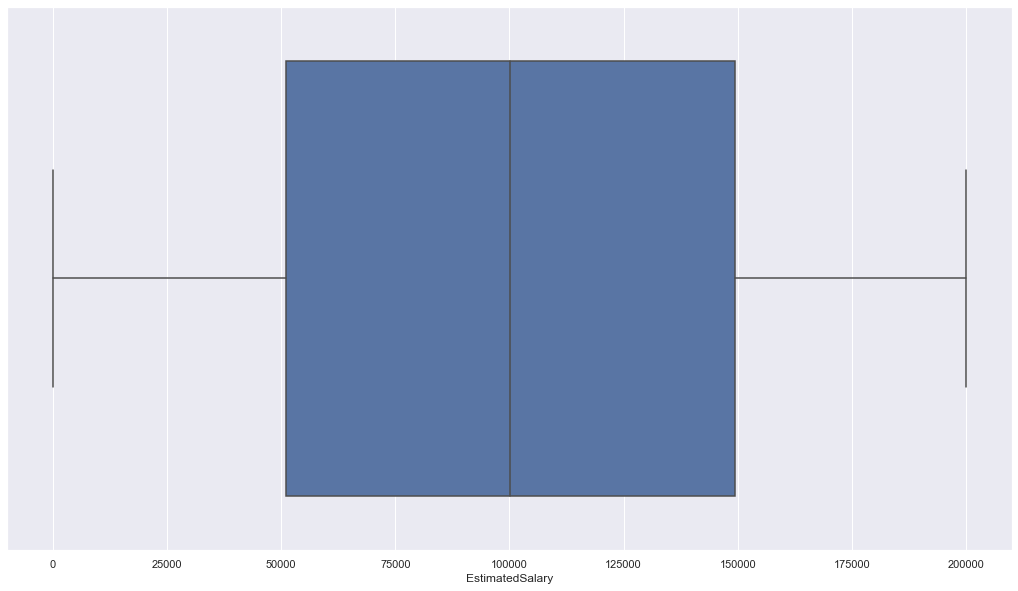

In [15]:
sns.boxplot(x = df2['EstimatedSalary'])

- The dataset is pretty cleaned, the gender encoding will be done after the EDA.

## Feature Engineering.

In [16]:
# Categorizing Balance values.

df2['BalanceCut'] = pd.cut(x=df2['Balance'], bins=[(df2['Balance'].min() - 1), 1000, 10000, 50000, 100000, 150000, 200000, (df2['Balance'].max() + 1)])

In [17]:
# Categorizing Estimated Salary accordingly to the average estimated salary

mean = df2['EstimatedSalary'].mean().round(2)
df2['MeanSalary'] = df2['EstimatedSalary'].apply(lambda x: 'Above' if x >= mean else 'Below')

In [18]:
# Categorizing Estimated Salary in 4 groups

df2['CatEstSalary'] = pd.cut(x=df2['EstimatedSalary'],
                             bins=[(df2['EstimatedSalary'].min() - 1),
                                   df2['EstimatedSalary'].describe()[4],
                                   df2['EstimatedSalary'].describe()[5],
                                   df2['EstimatedSalary'].describe()[6],
                                   df2['EstimatedSalary'].describe()[7] + 1])

## EDA

**EDA Planning:**

1. Univariate analysis.
2. Hypothesis formulation.
3. Bivariated analysis - hypothesis validation.
4. Multivariate analysis.

### Univariated Analysis - Pandas Profiling Report.

In [19]:
df3 = df2.copy()

In [20]:
df3.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceCut,MeanSalary,CatEstSalary
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(-1.0, 1000.0]",Above,"(100193.915, 149388.248]"
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(50000.0, 100000.0]",Above,"(100193.915, 149388.248]"
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(150000.0, 200000.0]",Above,"(100193.915, 149388.248]"
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(-1.0, 1000.0]",Below,"(51002.11, 100193.915]"
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(100000.0, 150000.0]",Below,"(51002.11, 100193.915]"


In [21]:
# Pandas Proffiling

report1 = ProfileReport(df3, 'Churn Prediction Dataset 1st Report')
report1.to_file(output_file = '../reports/pp_report1.html')

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
report1

### Hypothesis Formulation

H1. Male customers are mole likely to churn than female customers.

H2. Younger customers are mole likely to churn than older customers.

H3. Customers with less time as customers are mole likely to churn.

H4. Customers with less balance values are more likely to churn.

H5. Customer with less bank products are more likely to churn.

H6. Customer without creditcard are more likely to churn.

H7. Active members are less likely to churn.

H8. Customer with bigger estimated salary are less likely to churn.

H9. Customers from which country are more likely to exit?

### Bivariated analysis - hypothesis validation. 

#### H1. Male customers are mole likely to churn than female customers.

In [23]:
df_gender = df3.groupby(['Gender'])['Exited'].value_counts(normalize=True).round(3)
df_gender = df_gender.mul(100).rename('Percent').reset_index()

C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


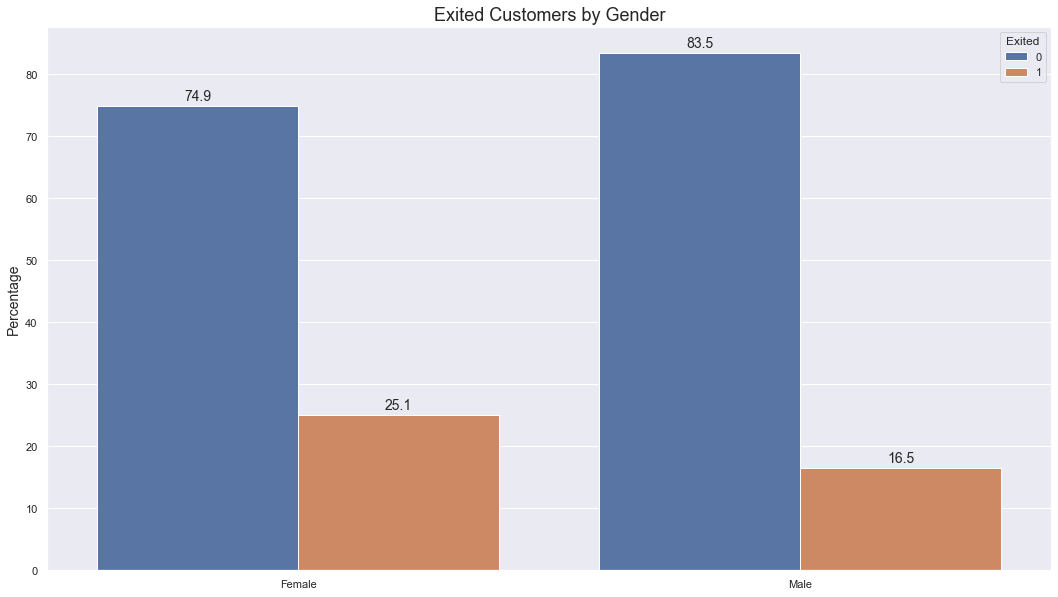

In [24]:
ax = sns.barplot('Gender', 'Percent', hue = 'Exited', data=df_gender)
ax.set_title('Exited Customers by Gender', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

**H1 Validation: FALSE**

    - Accordingly the data, women are more likely to churn than men.
        - More than 25% of women have exited the bank, while only 16,45% of man have exited.

#### H2. Younger customers are mole likely to churn than older customers.

In [25]:
df_age = df3.copy()
df_age['AgeGroup'] = df_age['Age'].apply(lambda x: 'Young' if x < 30 else 'Elder')

In [26]:
df_age = df_age.groupby('AgeGroup')['Exited'].value_counts(normalize=True).round(2)
df_age = df_age.mul(100).rename('Percent').reset_index()

C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


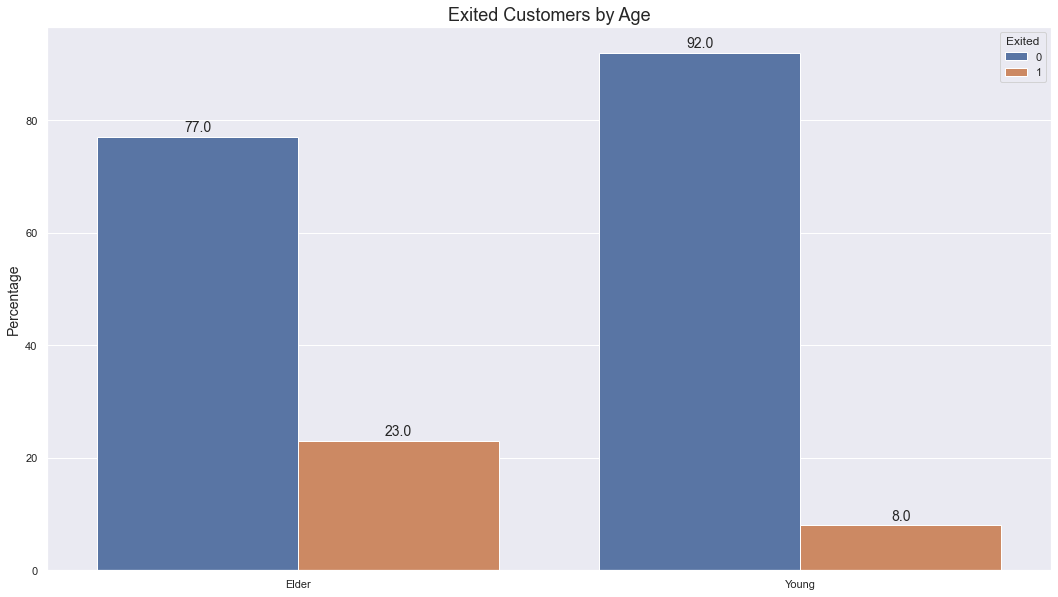

In [27]:
ax = sns.barplot('AgeGroup', 'Percent', hue = 'Exited', data=df_age)
ax.set_title('Exited Customers by Age', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

**H2 Validation: FALSE**

    - Accordingly the data, elder customers are more likely to churn than younger.
        - 23% of elder customers have exited the bank, while only 8% of younger customers have exited.

#### H3. Customers with less time as customers are mole likely to churn.

In [28]:
df_tenure = round(df3.groupby('Tenure')['Exited'].value_counts(normalize=True),2)
df_tenure = df_tenure.mul(100).rename('Percent').reset_index()

C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


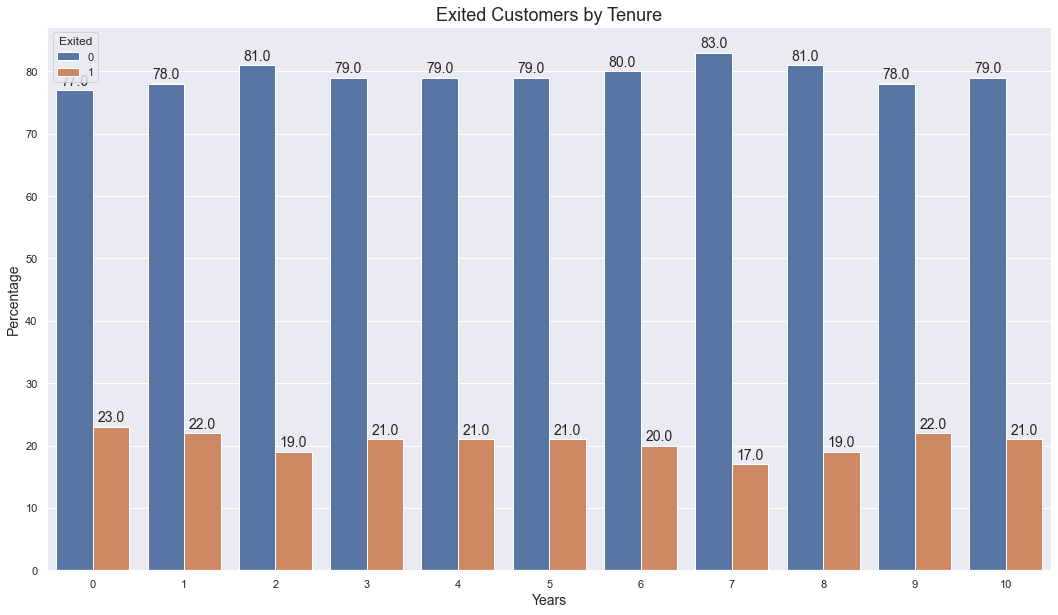

In [29]:
ax = sns.barplot('Tenure', 'Percent', hue = 'Exited', data=df_tenure)
ax.set_title('Exited Customers by Tenure', fontsize = 18)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax);

**H3 Validation: INCONCLUSIVE**

    - Accordingly the data, customers with less time as customers have almost the same exited proportion as customer with more time.
        - Customer with less than 4 years as customer have a range from 19% to 23% outings, while customer with more than 3 years have a range from 17% to 22%, almost the same.

#### H4. Customers with less balance values are more likely to churn.

<AxesSubplot:>

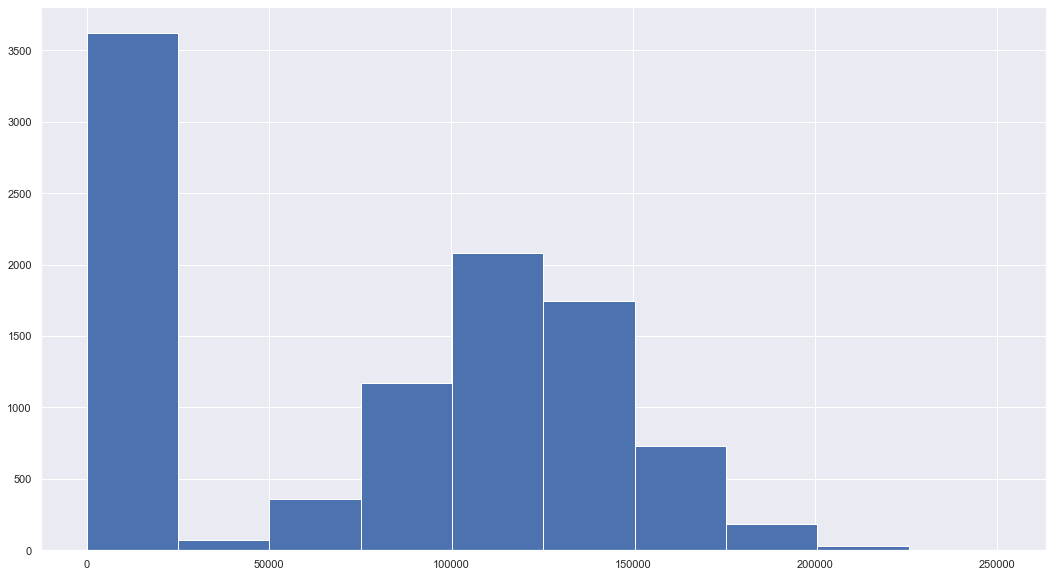

In [30]:
df3['Balance'].hist()

In [31]:
df_balance = round(df3.groupby('Exited')['Balance'].value_counts(normalize=True),2)
df_balance = df_balance.mul(100).rename('Percent').reset_index()

In [32]:
df3['BalanceCut'].value_counts()

(100000.0, 150000.0]     3830
(-1.0, 1000.0]           3617
(50000.0, 100000.0]      1509
(150000.0, 200000.0]      935
(10000.0, 50000.0]         74
(200000.0, 250899.09]      34
(1000.0, 10000.0]           1
Name: BalanceCut, dtype: int64

In [33]:
df_balance = df3.groupby('BalanceCut')['Exited'].value_counts(normalize=True).round(2)
df_balance2 = df3.groupby('BalanceCut')['Exited'].value_counts()
df_balance = df_balance.mul(100).rename('Percent').reset_index()
df_balance3 = pd.DataFrame(df_balance2).rename(columns = {'Exited':'Count'}).reset_index()

C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


''

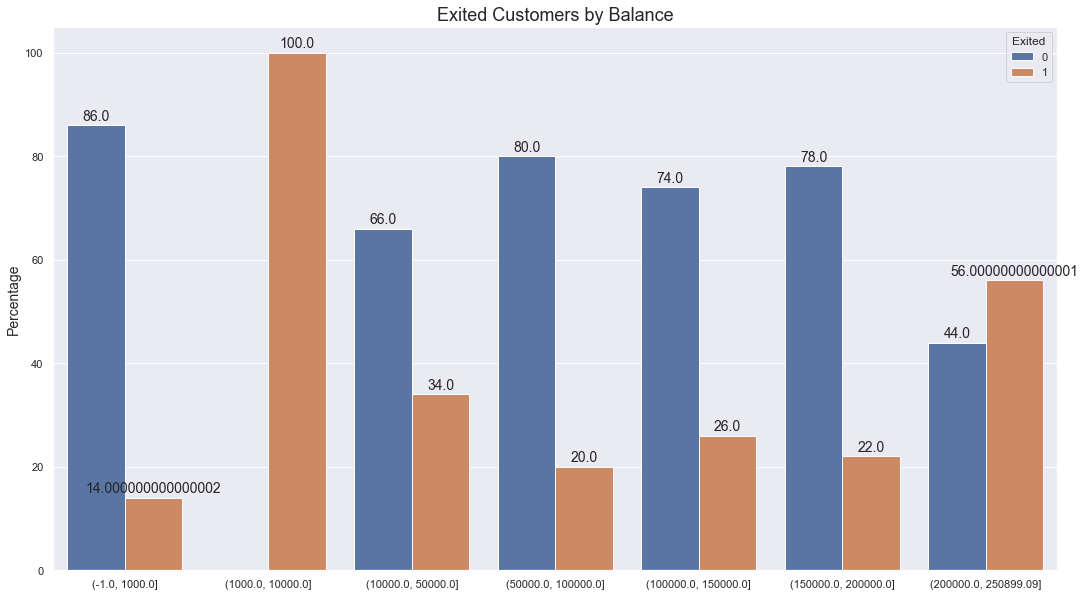

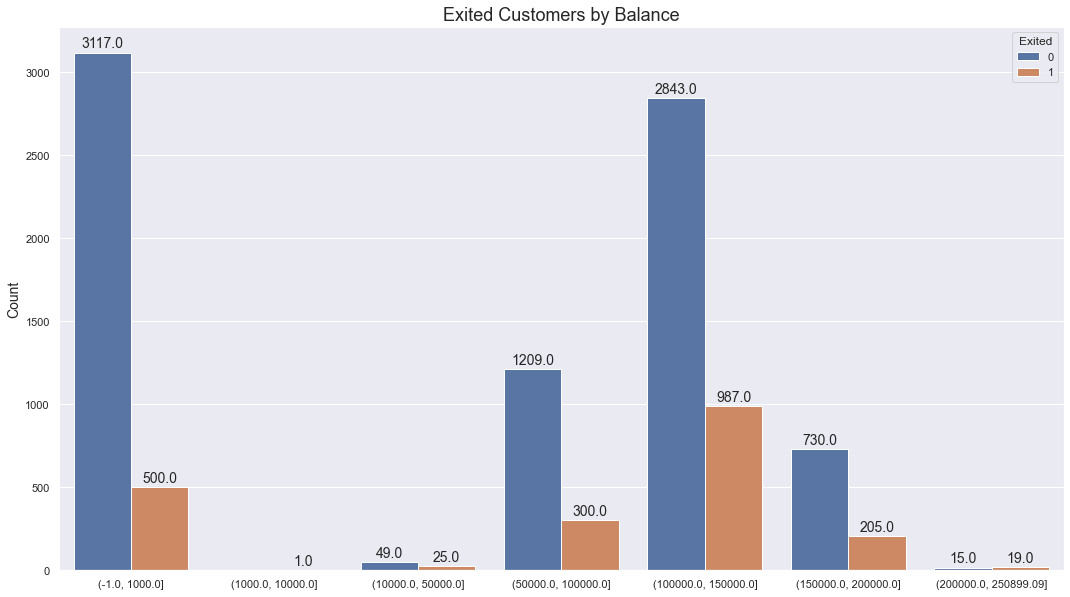

In [34]:
plt.subplots(1)

ax = sns.barplot('BalanceCut', 'Percent', hue = 'Exited', data=df_balance)
ax.set_title('Exited Customers by Balance', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot('BalanceCut', 'Count',  hue = 'Exited', data=df_balance3)
ax2.set_title('Exited Customers by Balance', fontsize = 18)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=14)
annot_plot(ax2)
;

In [35]:
display(df3[df3['Balance'] >= 10000]['Exited'].count())
display(df3[df3['Balance'] >= 10000]['Exited'].value_counts(normalize=True) * 100)

6382

0    75.93231
1    24.06769
Name: Exited, dtype: float64

In [36]:
display(df3[df3['Balance'] < 10000]['Exited'].count())
display(df3[df3['Balance'] < 10000]['Exited'].value_counts(normalize=True) * 100)

3618

0    86.15257
1    13.84743
Name: Exited, dtype: float64

**H4 Validation: FALSE**

    - Accordingly the data, customers with lower balance are more likely to remain customers.
        - Customer with balance lower than €10000 are more likely to remain customers. Only 13,8% of lower balance customers are 'Exited', while more than 24% of the customers with more than €10000 have exited.

#### H5. Customer with less bank products are more likely to churn.

In [37]:
df_prod = df3.groupby(['NumOfProducts'])['Exited'].value_counts(normalize=True).round(2)
df_prod = df_prod.mul(100).rename('Percent').reset_index()
df_prod2 = df3.groupby('NumOfProducts')['Exited'].value_counts()
df_prod3 = pd.DataFrame(df_prod2).rename(columns = {'Exited':'Count'}).reset_index()

C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


''

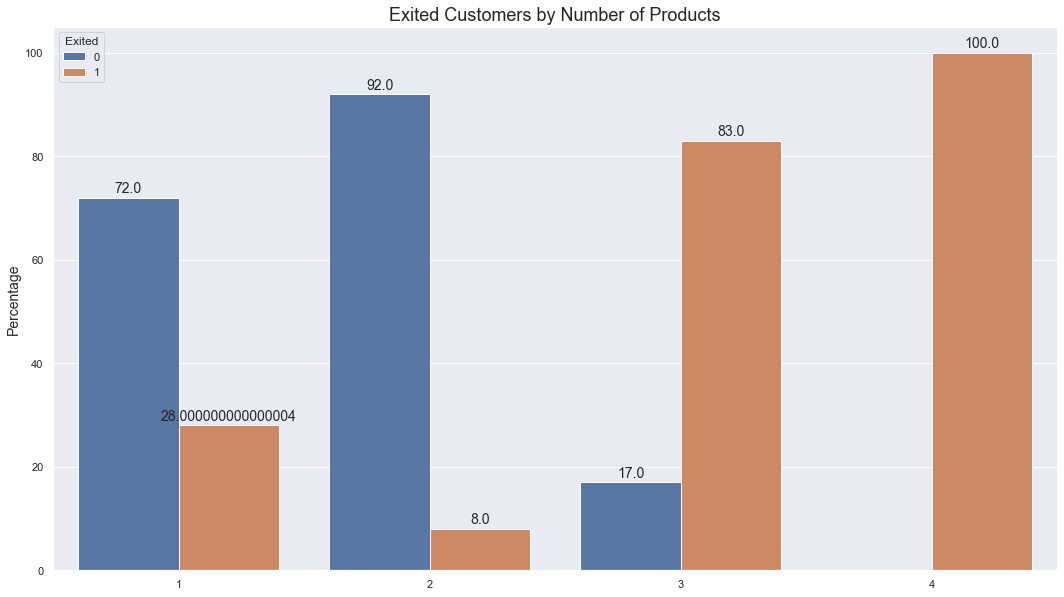

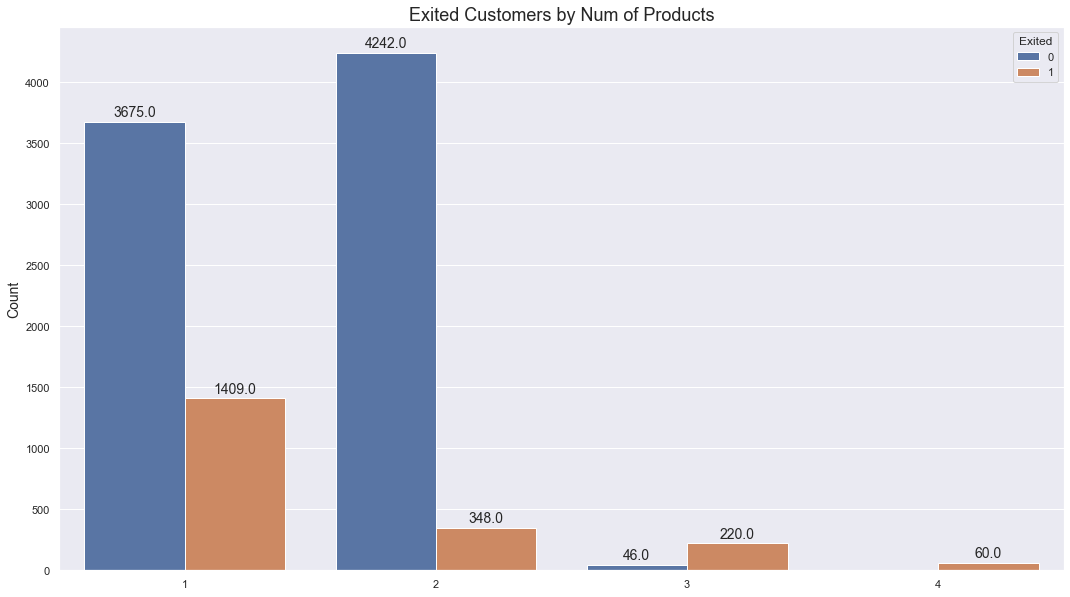

In [38]:
plt.subplots(1)

ax = sns.barplot('NumOfProducts', 'Percent', hue = 'Exited', data=df_prod)
ax.set_title('Exited Customers by Number of Products', fontsize = 18)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=14)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot('NumOfProducts', 'Count',  hue = 'Exited', data=df_prod3)
ax2.set_title('Exited Customers by Num of Products', fontsize = 18)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=14)
annot_plot(ax2)
;

**H5 Validation: FALSE**

    - Accordingly the data, customers with more products are more likely to exit.
        - 100% (60) customers with 4 products (higher) are exited, 83% of customers with 3 products are exited, only 8% of customers with 2 products are exited and 28% of customers with 1 prouct are exited. So customers with more products are more likely to be exited.

#### H6. Customer without creditcard are more likely to churn.

In [39]:
df_cc = df3.groupby(['HasCrCard'])['Exited'].value_counts(normalize=True).round(2)
df_cc = df_cc.mul(100).rename('Percent').reset_index()
df_cc2 = df3.groupby(['HasCrCard'])['Exited'].value_counts()
df_cc2 = pd.DataFrame(df_cc2).rename(columns = {'Exited':'Count'}).reset_index()

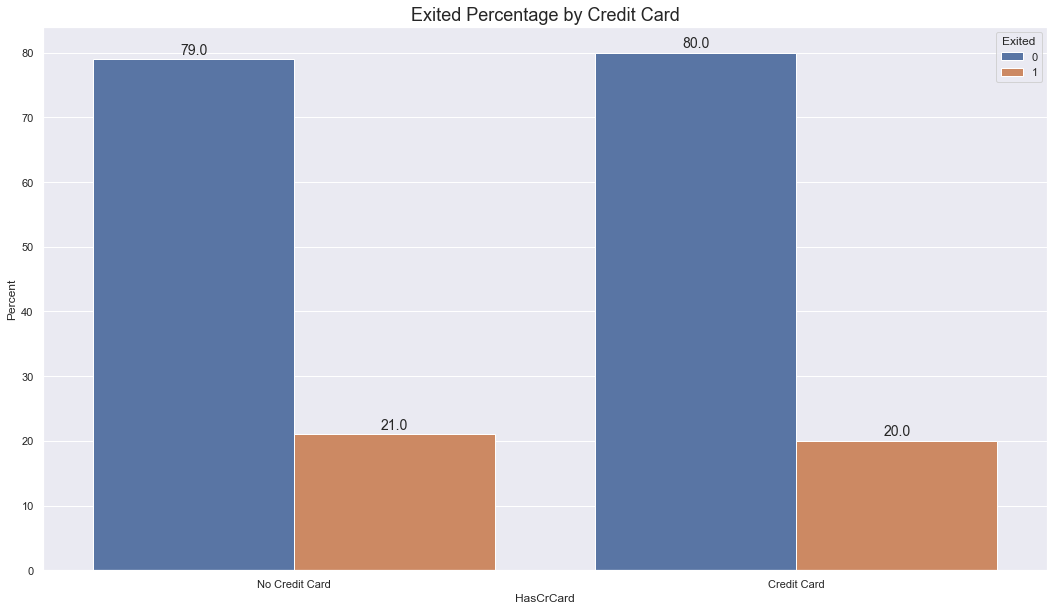

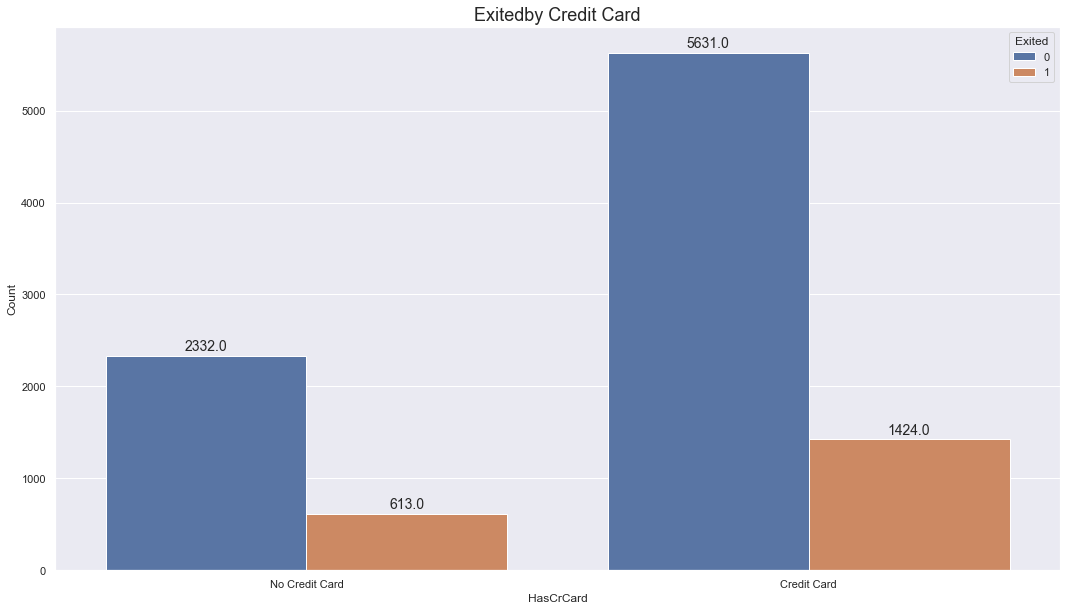

In [40]:
plt.subplots(1)

ax = sns.barplot(x = 'HasCrCard', y = 'Percent' ,hue = 'Exited', data = df_cc)
ax.set_xticklabels(['No Credit Card', 'Credit Card'])
ax.set_title('Exited Percentage by Credit Card', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'HasCrCard', y = 'Count' ,hue = 'Exited', data = df_cc2)
ax2.set_xticklabels(['No Credit Card', 'Credit Card'])
ax2.set_title('Exitedby Credit Card', fontsize = 18)
annot_plot(ax2)

**H6 Validation: INCONCLUSIVE**

    - Accordingly the data, customers with and without credit card have the same behavior related to remain or not in the bank.
        - The difference between the has or not a credit card is not significant. 20% of customers with credit card has exited against 21% of customers without credit card.

#### H7. Active members are less likely to churn.

In [41]:
df_act = round(df3.groupby(['IsActiveMember'])['Exited'].value_counts(normalize=True),2)
df_act = df_act.mul(100).rename('Percent').reset_index()
df_act2 = df3.groupby(['IsActiveMember'])['Exited'].value_counts()
df_act2 = pd.DataFrame(df_act2).rename(columns = {'Exited':'Count'}).reset_index()

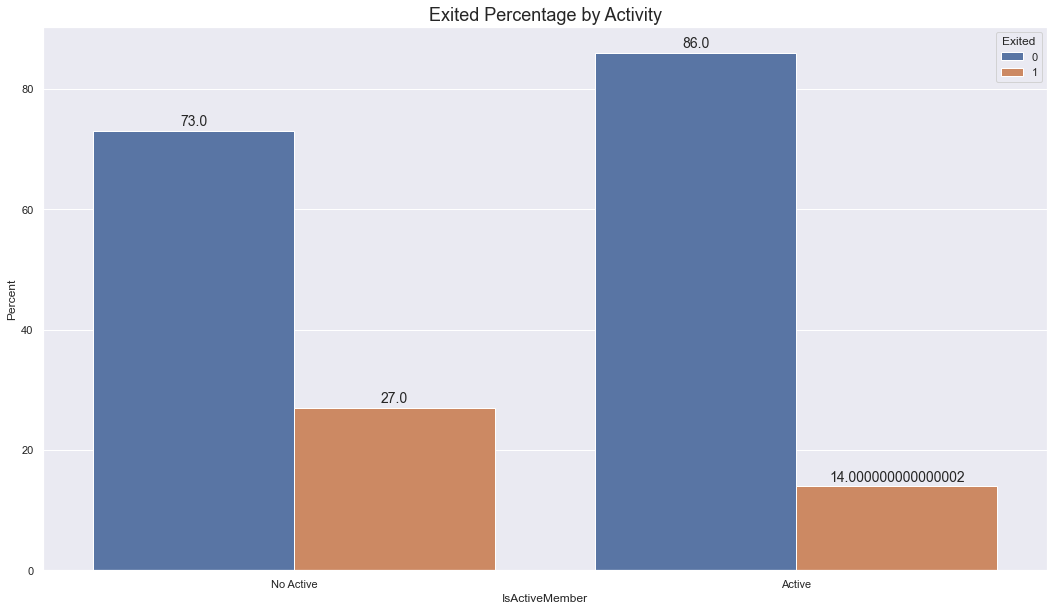

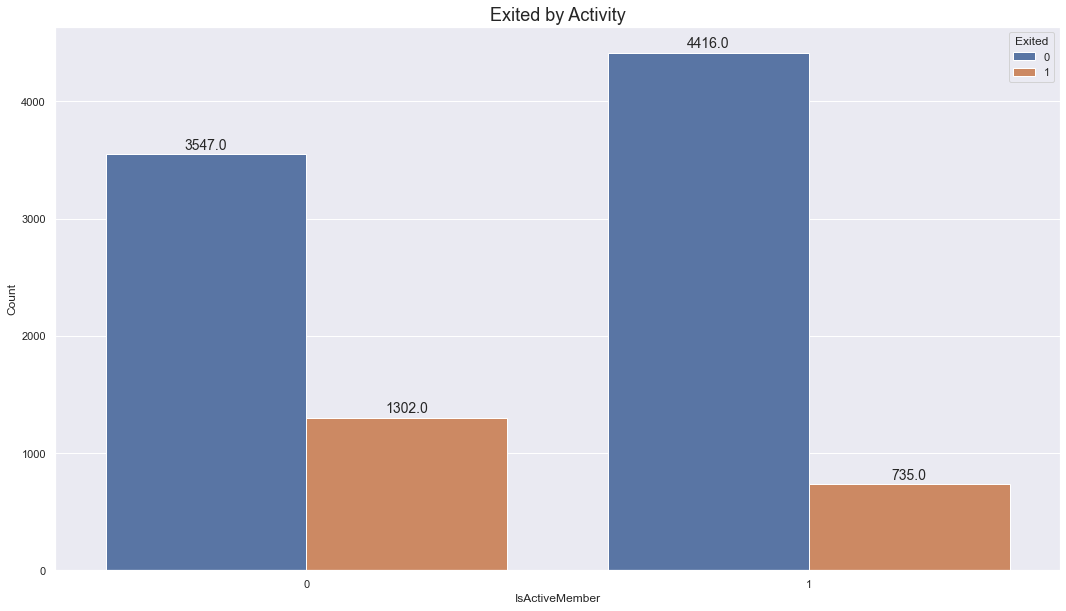

In [42]:
plt.subplots(1)

ax = sns.barplot(x = 'IsActiveMember', y = 'Percent' ,hue = 'Exited', data = df_act)
ax.set_xticklabels(['No Active', 'Active'])
ax.set_title('Exited Percentage by Activity', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'IsActiveMember', y = 'Count' ,hue = 'Exited', data = df_act2)
ax.set_xticklabels(['No Active', 'Active'])
ax2.set_title('Exited by Activity', fontsize = 18)
annot_plot(ax2)

**H7 Validation: TRUE**

    - Accordingly the data, active members are more likely to remain, where only 14% are exited. Not active members have 27% of exited customers. 

#### H8. Customer with estimated salary bigger than the average are less likely to churn.

In [43]:
df_ms = round(df3.groupby(['MeanSalary'])['Exited'].value_counts(normalize=True),2)
df_ms = df_ms.mul(100).rename('Percent').reset_index()
df_ms2 = df3.groupby(['MeanSalary'])['Exited'].value_counts()
df_ms2 = pd.DataFrame(df_ms2).rename(columns = {'Exited':'Count'}).reset_index()

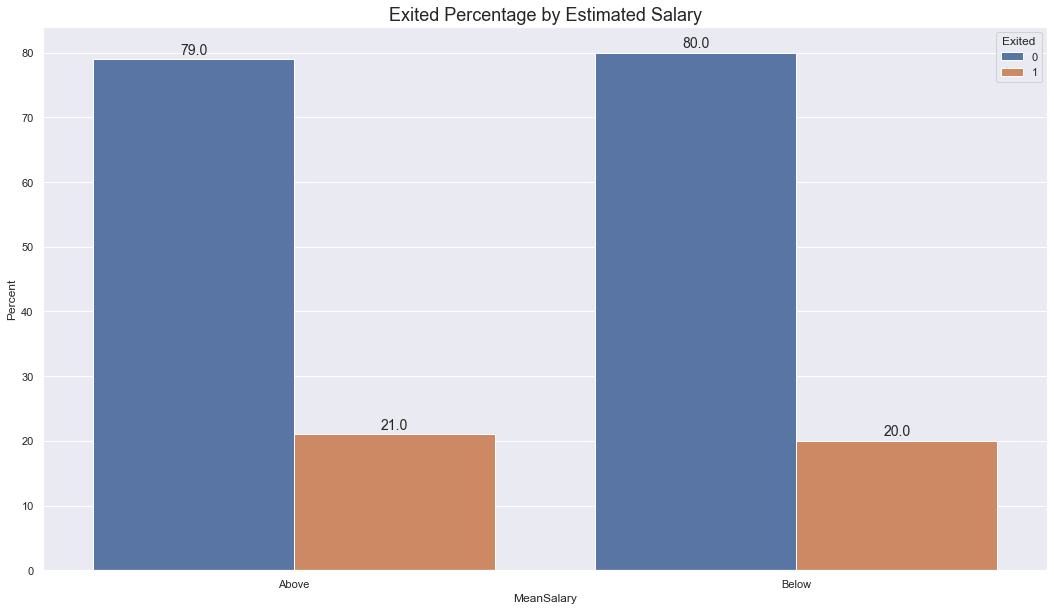

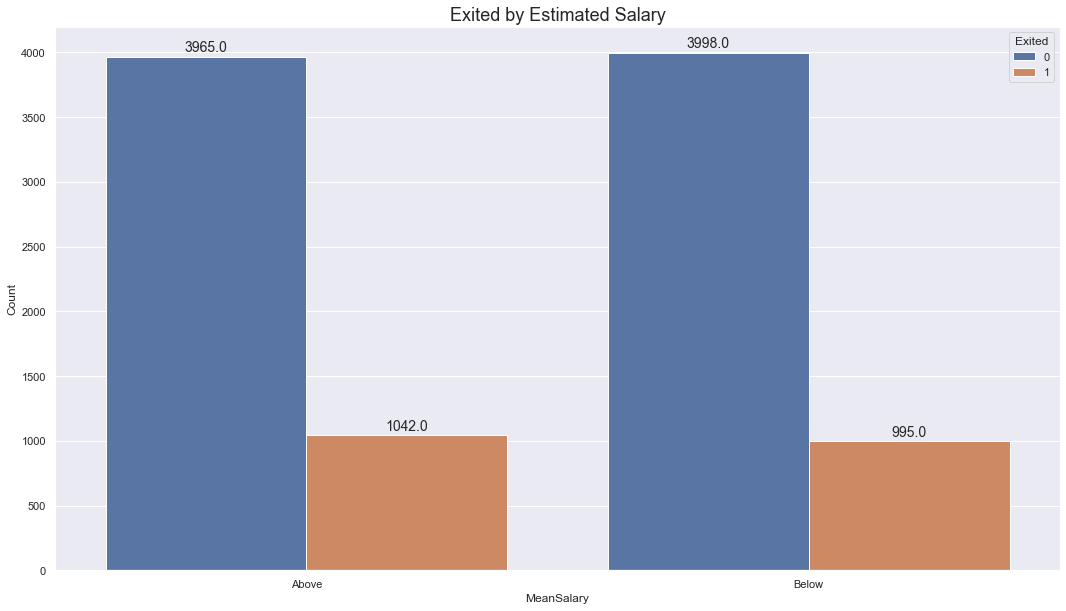

In [44]:
plt.subplots(1)

ax = sns.barplot(x = 'MeanSalary', y = 'Percent' ,hue = 'Exited', data = df_ms)
ax.set_title('Exited Percentage by Estimated Salary', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'MeanSalary', y = 'Count' ,hue = 'Exited', data = df_ms2)
ax2.set_title('Exited by Estimated Salary', fontsize = 18)
annot_plot(ax2)

In [45]:
df_ms3 = round(df3.groupby(['CatEstSalary'])['Exited'].value_counts(normalize=True),2)
df_ms3 = df_ms3.mul(100).rename('Percent').reset_index()
df_ms4 = df3.groupby(['CatEstSalary'])['Exited'].value_counts()
df_ms4 = pd.DataFrame(df_ms4).rename(columns = {'Exited':'Count'}).reset_index()

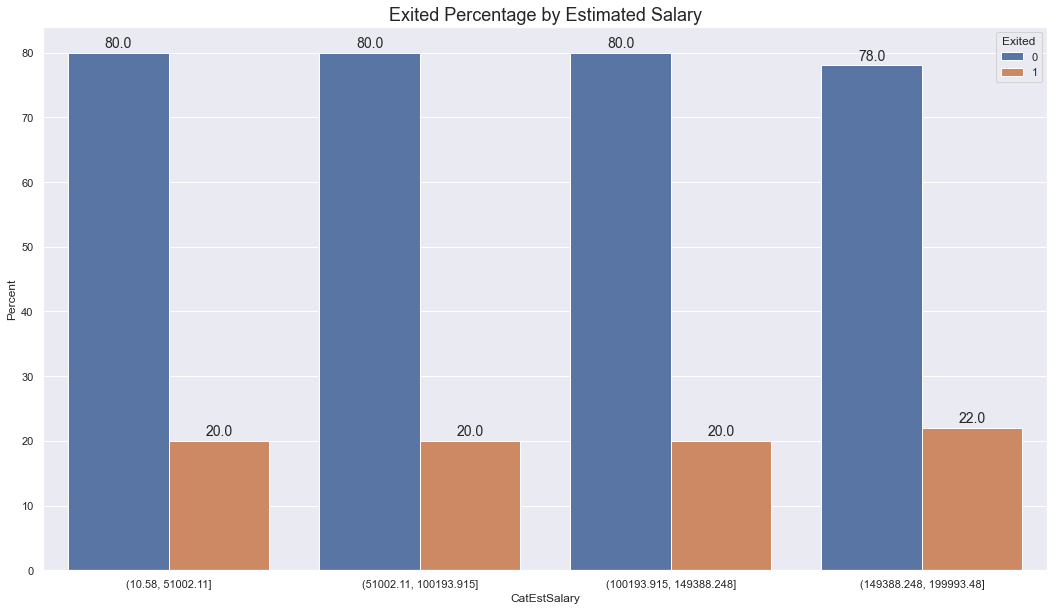

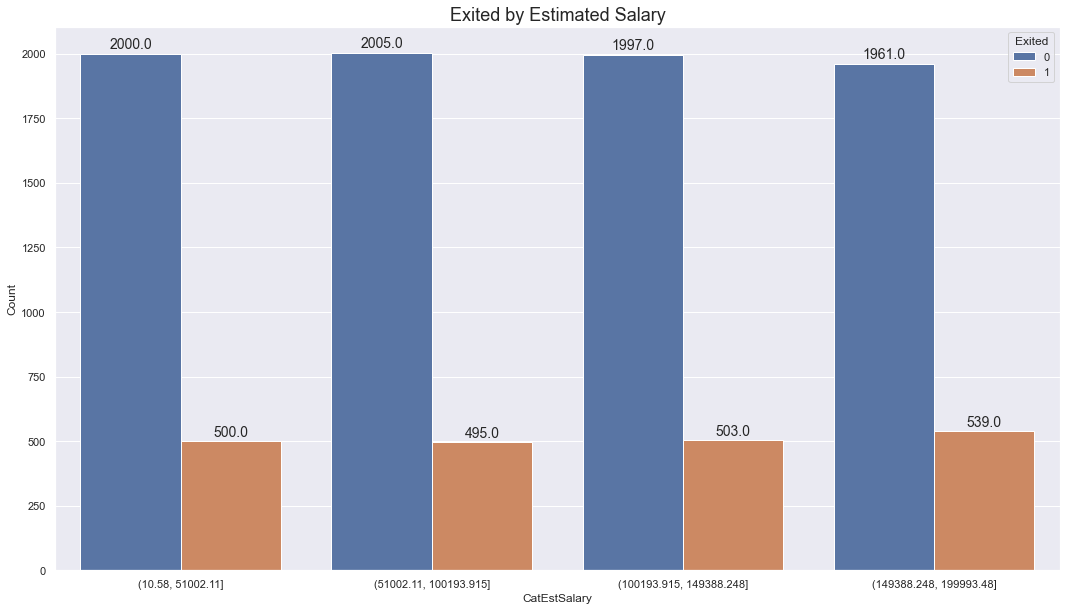

In [46]:
plt.subplots(1)

ax = sns.barplot(x = 'CatEstSalary', y = 'Percent' ,hue = 'Exited', data = df_ms3)
ax.set_title('Exited Percentage by Estimated Salary', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'CatEstSalary', y = 'Count' ,hue = 'Exited', data = df_ms4)
ax2.set_title('Exited by Estimated Salary', fontsize = 18)
annot_plot(ax2)

**H8 Validation: INCONCLUSIVE**

    - Accordingly the data, the an estimated salary above or below the average has no influence if the customer will or will not remain as customer.
    - This is very weird, the data is very well balanced when it is divided in 4 accordingly with min, 25%, 50%, 75% and max estimated salary.

#### H9. Customers from which country are more likely to exit?

In [47]:
df_ct = round(df3.groupby(['Geography'])['Exited'].value_counts(normalize=True),2)
df_ct = df_ct.mul(100).rename('Percent').reset_index()
df_ct2 = df3.groupby(['Geography'])['Exited'].value_counts()
df_ct2 = pd.DataFrame(df_ct2).rename(columns = {'Exited':'Count'}).reset_index()

In [48]:
df_ct2

,Geography,Exited,Count
0,France,0,4204
1,France,1,810
2,Germany,0,1695
3,Germany,1,814
4,Spain,0,2064
5,Spain,1,413


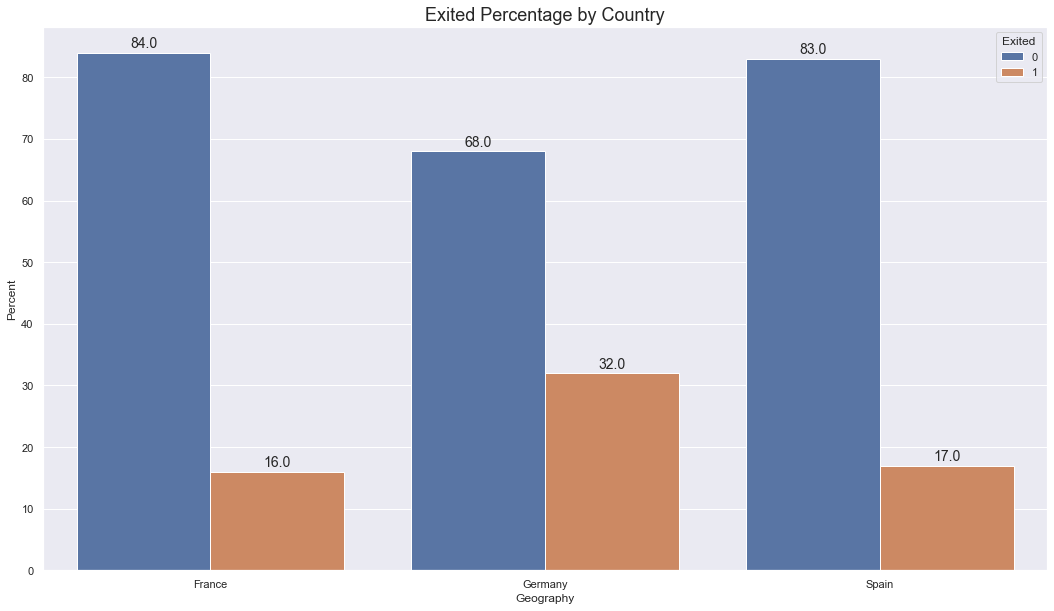

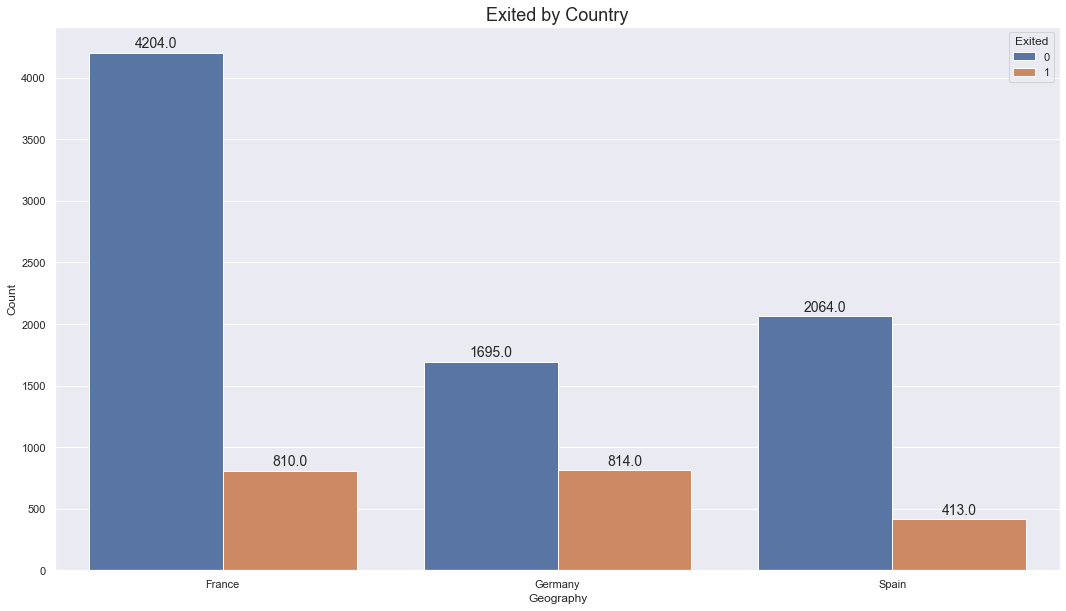

In [49]:
plt.subplots(1)

ax = sns.barplot(x = 'Geography', y = 'Percent' ,hue = 'Exited', data = df_ct)
ax.set_title('Exited Percentage by Country', fontsize = 18)
annot_plot(ax)

plt.subplots(1)

ax2 = sns.barplot(x = 'Geography', y = 'Count' ,hue = 'Exited', data = df_ct2)
ax2.set_title('Exited by Country', fontsize = 18)
annot_plot(ax2)

**H8: Germany**

    - Germany is by far the country with more exited customers, 32%, followed by Spain, 17% and France, 16%.

### Multivariated Analysis.

<AxesSubplot:>

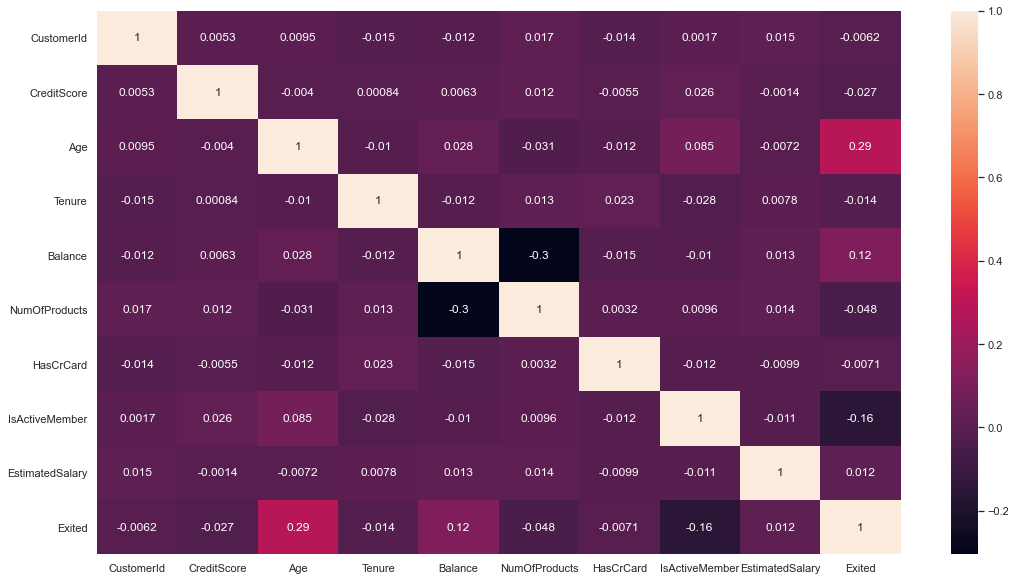

In [50]:
sns.heatmap(df3.corr(method='pearson'), annot=True)

## Data Preparation

In [71]:
# Excluded Columns - "Surname", "Balance", "Exited", "MeanSalary"

df4 = df3[
    ['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age',
     'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
     'EstimatedSalary', 'BalanceCut', 
     'CatEstSalary']
]

### Encoding Categorical Variables

In [72]:
df4.dtypes

CustomerId            int64
CreditScore           int64
Geography            object
Gender               object
Age                   int64
Tenure                int64
NumOfProducts         int64
HasCrCard             int64
IsActiveMember        int64
EstimatedSalary     float64
BalanceCut         category
CatEstSalary       category
dtype: object

In [73]:
# Encoding categorical features

# Geografphy
df4 = pd.get_dummies(df4, prefix = 'Geo', columns = ['Geography'])

# Gender
gender = {
    'Male':1, 
    'Female':2
}
df4['Gender'] = df['Gender'].map(gender)

encoder = OrdinalEncoder()

# BalanceCut
df4['BalanceCut'] = encoder.fit_transform(np.array(df4['BalanceCut']).reshape(-1,1))

# CatEstSalary
df4['CatEstSalary'] = encoder.fit_transform(np.array(df4['CatEstSalary']).reshape(-1,1))

### Rescaling numerical features.

C:\Users\felip\Anaconda3\envs\PA05\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


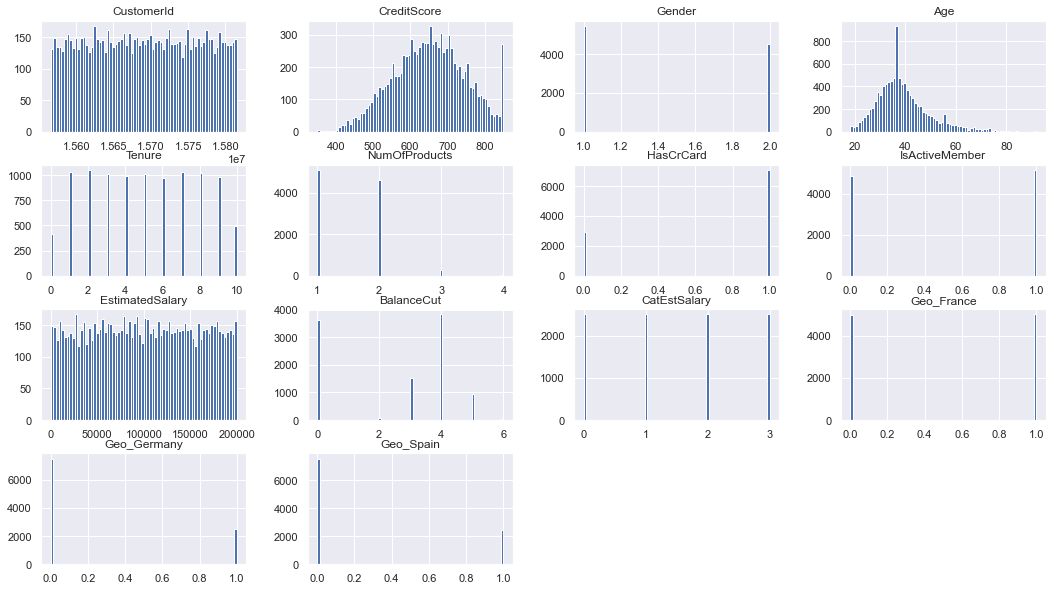

In [74]:
# Rescaling numerical features

df4.hist(bins=70);

#### StandardScaler

In [75]:
# Credit Score - distribution close to a normal.

ss = StandardScaler()

df4['CreditScore'] = ss.fit_transform(df4[['CreditScore']].values)

#### MinMaxScaler

In [76]:
mms = MinMaxScaler()

# Age
df4['Age'] = mms.fit_transform(df4[['Age']].values)

# Tenure
df4['Tenure'] = mms.fit_transform(df4[['Tenure']].values)

# Estimated Salary
df4['EstimatedSalary'] = mms.fit_transform(df4[['EstimatedSalary']].values)

# Num of products
df4['NumOfProducts'] = mms.fit_transform(df4[['NumOfProducts']].values)

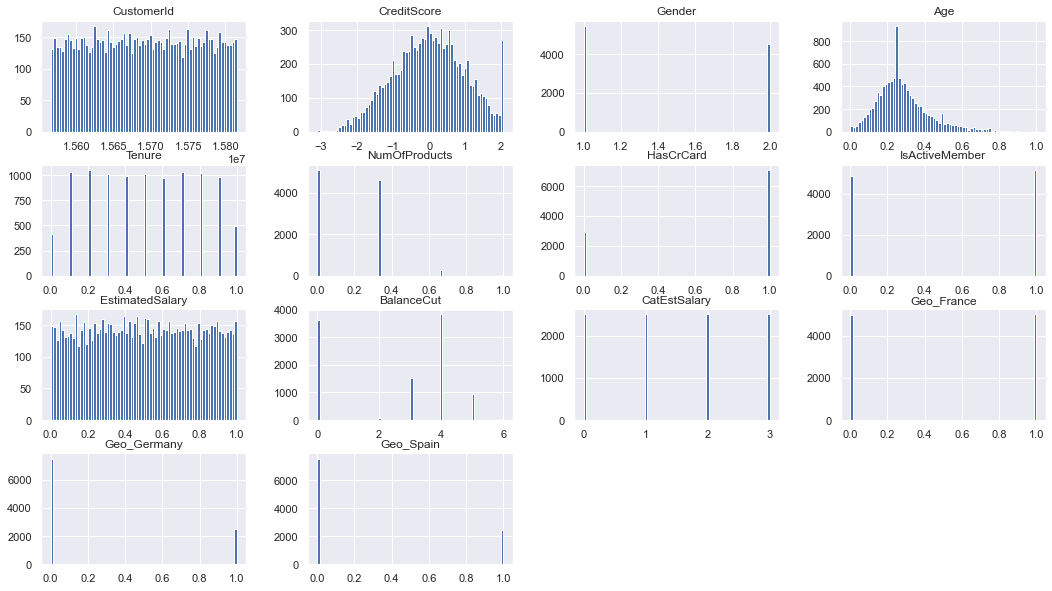

In [79]:
df4.hist(bins=70);

#### Data Balancing

<AxesSubplot:xlabel='Exited', ylabel='count'>

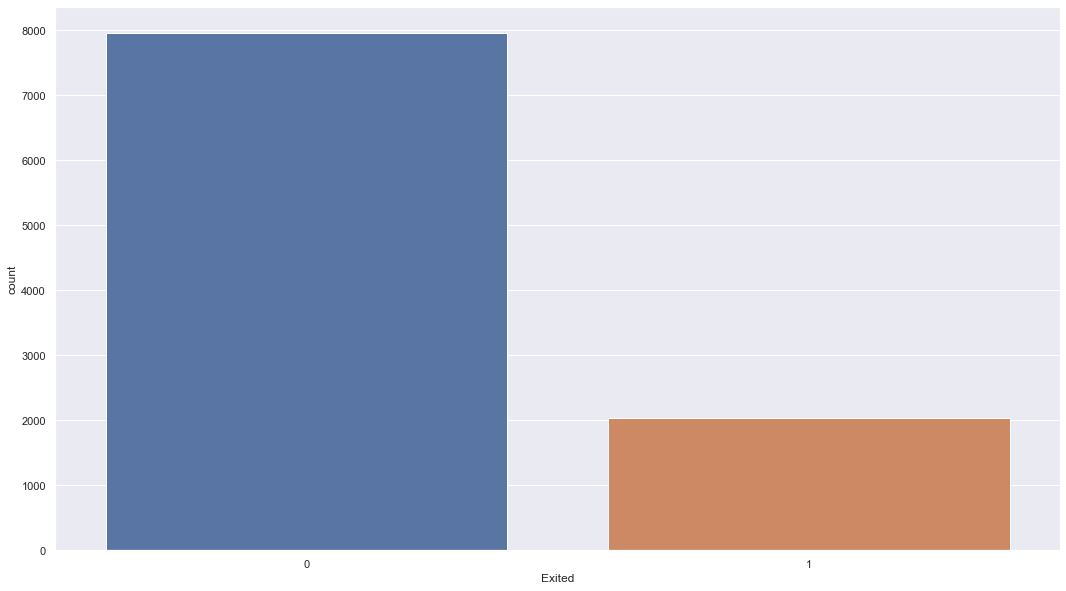

In [81]:
sns.countplot(x=df3['Exited'])

In [ ]:
# Smote Tomek algorithm

